0. Setup


In [34]:
# Start by importing the relevant libraries.
# Copied from Archit's Audio Main Model.
import os
import glob
import pandas as pd
import numpy as np
import pickle
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision.models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchaudio
import torchaudio.transforms as T
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, Subset, Dataset
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

1. Data Processing


In [35]:
# Import the dataset from the .pt file.
images_overall_dataset = torch.load('../../Data/bird_dataset.pt')

/var/folders/s8/7wj664s92gx_89p1xhcwbq800000gn/T/ipykernel_14536/1541596894.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  images_overall_dataset = torch.load('../../Da

In [36]:
# Extract the features and labels from the dataset.
images_features = images_overall_dataset['images']
images_labels = images_overall_dataset['labels']

print("Shape of images_features: ", images_features.shape)
print("Shape of images_labels: ", images_labels.shape)

Shape of images_features:  torch.Size([12325, 3, 224, 224])
Shape of images_labels:  torch.Size([12325])


In [37]:
# Now we need to load the .csv file that contains the birds we care about.
birds_df = pd.read_csv('../../Data Processing/chosen_classes_47_data_stats.csv')
birds_df.head()

,Index,Class ID,Images Count,XC Recordings Count,Species Name,XC Species Name
0,0,315,116,169,Gadwall (Breeding male),Gadwall
1,1,317,120,243,Mallard (Breeding male),Mallard
2,2,352,120,283,Black-crowned Night-Heron (Adult),Black-crowned Night Heron
3,3,400,117,335,Herring Gull (Adult),Herring Gull
4,4,450,120,365,Common Tern,Common Tern


In [38]:
# Now we want to traverse through the labels tensor and only keep the 
# labels and accordingly the features that are in the birds_df dataframe.

# Create lists to store these filtered tensors.
filtered_images_features = []
filtered_images_labels = []
for i in range(len(images_labels)):
    if images_labels[i].item() in birds_df['Class ID'].values:
        filtered_images_features.append(images_features[i])
        filtered_images_labels.append(images_labels[i])

# Stack the tensors to create a single tensor.
filtered_images_features = torch.stack(filtered_images_features)
filtered_images_labels = torch.tensor(filtered_images_labels)

print("Shape of filtered_images_features: ", filtered_images_features.shape)
print("Shape of filtered_images_labels: ", filtered_images_labels.shape)

Shape of filtered_images_features:  torch.Size([5469, 3, 224, 224])
Shape of filtered_images_labels:  torch.Size([5469])


In [39]:
# Now we encode the labels to make them more suitable for training.
# We can use the same mappings as the ones used for the other two models.
# These mappings are stored in label_mappings.pkl.

# Load the label mappings from the pickle file.
with open('label_mappings.pkl','rb') as f:
    label_mappings = pickle.load(f)

# Encode the labels using the mappings.
label_encoder = LabelEncoder()
label_encoder.fit(list(label_mappings['index_to_id'].values()))
encoded_labels = label_encoder.transform(filtered_images_labels.numpy())
# Convert the encoded labels back to a tensor.
encoded_labels_tensor = torch.tensor(encoded_labels)

print("Shape of encoded_labels_tensor: ", encoded_labels_tensor.shape)

Shape of encoded_labels_tensor:  torch.Size([5469])


In [40]:
# Now we move on to splitting the data into training, validation, and test sets.
# We will use a stratified split to ensure uniform distribution of classes.

# Get labels as numpy array.
labels_np = encoded_labels_tensor.numpy()
# Use the labels np array to create indices array.
indices = np.arange(len(labels_np))

# First Split: train + val vs test - 80:20
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
temp_idx, test_idx = next(sss1.split(indices, labels_np))

# Get the temporary set.
temp_indices = np.arange(len(temp_idx))
temp_labels_np = labels_np[temp_idx]

# Second Split: train vs val - 80:20
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_temp_idx, val_temp_idx = next(sss2.split(temp_indices, temp_labels_np))

# Convert to original indices.
train_idx = temp_idx[train_temp_idx]
val_idx = temp_idx[val_temp_idx]

In [41]:
# Create the full dataset,
full_dataset = TensorDataset(filtered_images_features, encoded_labels_tensor)

In [42]:
# Function to create an upsampled dataset.
def create_upsampled_dataset(full_dataset, train_idx, target_samples_per_class=200):
    # Create initial subset with training indices
    initial_train_dataset = Subset(full_dataset, train_idx)
    
    # Extract labels for all training samples
    train_labels = []
    for idx in train_idx:
        _, label = full_dataset[idx]  # Assuming dataset returns (data, label)
        train_labels.append(label.item())
    
    # Count samples per class
    class_counts = Counter(train_labels)
    print(f"Original class distribution: {dict(class_counts)}")
    
    # Identify classes that need oversampling
    classes_to_oversample = {cls: target_samples_per_class - count 
                             for cls, count in class_counts.items() 
                             if count < target_samples_per_class}
    
    if not classes_to_oversample:
        print("No oversampling needed - all classes have enough samples")
        return initial_train_dataset
    
    # Group indices by class
    class_indices = {cls: [] for cls in class_counts.keys()}
    for i, idx in enumerate(train_idx):
        class_indices[train_labels[i]].append(idx)
    
    # Create oversampled indices
    additional_indices = []
    
    for cls, num_needed in classes_to_oversample.items():
        cls_indices = class_indices[cls]
        # Randomly sample with replacement from the class
        oversampled_indices = np.random.choice(cls_indices, size=num_needed, replace=True)
        additional_indices.extend(oversampled_indices)
    
    # Combine original indices with oversampled indices
    all_indices = list(train_idx) + additional_indices
    
    # Create final balanced dataset
    upsampled_train_dataset = Subset(full_dataset, all_indices)
    
    # Verify the new distribution
    upsampled_labels = []
    for idx in all_indices:
        _, label = full_dataset[idx]
        upsampled_labels.append(label.item())
    
    balanced_counts = Counter(upsampled_labels)
    print(f"Balanced class distribution: {dict(balanced_counts)}")
    
    return upsampled_train_dataset

In [43]:
# Use the full dataset and the indices generated above to create the train, val, and test datasets.
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

print("Length of train_dataset: ", len(train_dataset))
print("Length of val_dataset: ", len(val_dataset))
print("Length of test_dataset: ", len(test_dataset))

Length of train_dataset:  3500
Length of val_dataset:  875
Length of test_dataset:  1094


2. AlexNet Feature Extraction


In [44]:
"""FOR MACBOOK LOCAL SETUP USERS ONLY """
use_mps = True
# Set device to GPU if available
device = torch.device("mps") if use_mps and torch.backends.mps.is_available() else torch.device("cpu")

In [11]:
# Import the AlexNet model.
alexnet = torchvision.models.alexnet(pretrained=True)

/opt/anaconda3/envs/ECE421/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ECE421/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Use the model to extract features for each of the datasets.
# Start with the training dataset.
alexnet_train_features = []
alexnet_train_labels = []
for data in train_dataset:
    # Extract the image and the label.
    image, label = data
    # Extract the features from the image.
    features = alexnet.features(image).detach()
    # Append the features and the label to the lists.
    alexnet_train_features.append(features)
    alexnet_train_labels.append(label)

# Stack the features and labels to create a single tensor.
alexnet_train_features = torch.stack(alexnet_train_features)
alexnet_train_labels = torch.tensor(alexnet_train_labels)
print("Shape of alexnet_train_features: ", alexnet_train_features.shape)
print("Shape of alexnet_train_labels: ", alexnet_train_labels.shape)

Shape of alexnet_train_features:  torch.Size([3500, 256, 6, 6])
Shape of alexnet_train_labels:  torch.Size([3500])


In [13]:
# Do the same for the validation dataset.
alexnet_val_features = []
alexnet_val_labels = []
for data in val_dataset:
    # Extract the image and the label.
    image, label = data
    # Extract the features from the image.
    features = alexnet.features(image).detach()
    # Append the features and the label to the lists.
    alexnet_val_features.append(features)
    alexnet_val_labels.append(label)
# Stack the features and labels to create a single tensor.
alexnet_val_features = torch.stack(alexnet_val_features)
alexnet_val_labels = torch.tensor(alexnet_val_labels)

print("Shape of alexnet_val_features: ", alexnet_val_features.shape)
print("Shape of alexnet_val_labels: ", alexnet_val_labels.shape)

Shape of alexnet_val_features:  torch.Size([875, 256, 6, 6])
Shape of alexnet_val_labels:  torch.Size([875])


In [14]:
# Now we move on to the testing dataset.
alexnet_test_features = []
alexnet_test_labels = []
for data in test_dataset:
    # Extract the image and the label.
    image, label = data
    # Extract the features from the image.
    features = alexnet.features(image).detach()
    # Append the features and the label to the lists.
    alexnet_test_features.append(features)
    alexnet_test_labels.append(label)
# Stack the features and labels to create a single tensor.
alexnet_test_features = torch.stack(alexnet_test_features)
alexnet_test_labels = torch.tensor(alexnet_test_labels)

print("Shape of alexnet_test_features: ", alexnet_test_features.shape)
print("Shape of alexnet_test_labels: ", alexnet_test_labels.shape)

Shape of alexnet_test_features:  torch.Size([1094, 256, 6, 6])
Shape of alexnet_test_labels:  torch.Size([1094])


In [15]:
# Use these extracted features to create datasets.
alexnet_train_dataset = TensorDataset(alexnet_train_features, alexnet_train_labels)
alexnet_val_dataset = TensorDataset(alexnet_val_features, alexnet_val_labels)
alexnet_test_dataset = TensorDataset(alexnet_test_features, alexnet_test_labels)

print("Length of alexnet_train_dataset: ", len(alexnet_train_dataset))
print("Length of alexnet_val_dataset: ", len(alexnet_val_dataset))
print("Length of alexnet_test_dataset: ", len(alexnet_test_dataset))

Length of alexnet_train_dataset:  3500
Length of alexnet_val_dataset:  875
Length of alexnet_test_dataset:  1094


3. ResNet Feature Extraction


In [45]:
# Import the ResNet model.
resnet = torchvision.models.resnet18(pretrained=True)

/opt/anaconda3/envs/ECE421/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ECE421/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/architbhargava/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


In [46]:
# Replace the final fully connected layer with an identify so that the model 
# outputs the feature vector directly.
resnet.fc = nn.Identity()
# Set the model to evaluation mode.
resnet.eval()
# Shift reset to the device.
resnet.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
# Use the ResNet model to extract features for each of the datasets.
# Start with the training dataset.
resnet_train_features = []
resnet_train_labels = []
for data in train_dataset:
    # Extract the image and the label.
    image, label = data
    image = image.unsqueeze(0)
    image = image.to(device)
    # Extract the features from the image.
    features = resnet(image).detach()
    # Append the features and the label to the lists.
    resnet_train_features.append(features)
    resnet_train_labels.append(label)

# Stack the features and labels to create a single tensor.
resnet_train_features = torch.stack(resnet_train_features)
resnet_train_labels = torch.tensor(resnet_train_labels)
print("Shape of resnet_train_features: ", resnet_train_features.shape)
print("Shape of resnet_train_labels: ", resnet_train_labels.shape)

Shape of resnet_train_features:  torch.Size([3500, 1, 512])
Shape of resnet_train_labels:  torch.Size([3500])


In [50]:
# Next, we do the same for the validation dataset.
resnet_val_features = []
resnet_val_labels = []
for data in val_dataset:
    # Extract the image and the label.
    image, label = data
    image = image.unsqueeze(0)
    image = image.to(device)
    # Extract the features from the image.
    features = resnet(image).detach()
    # Append the features and the label to the lists.
    resnet_val_features.append(features)
    resnet_val_labels.append(label)

# Stack the features and labels to create a single tensor.
resnet_val_features = torch.stack(resnet_val_features)
resnet_val_labels = torch.tensor(resnet_val_labels)
print("Shape of resnet_val_features: ", resnet_val_features.shape)
print("Shape of resnet_val_labels: ", resnet_val_labels.shape)


Shape of resnet_val_features:  torch.Size([875, 1, 512])
Shape of resnet_val_labels:  torch.Size([875])


In [51]:
# Last, we move on to the testing dataset.
resnet_test_features = []
resnet_test_labels = []
for data in test_dataset:
    # Extract the image and the label.
    image, label = data
    image = image.unsqueeze(0)
    image = image.to(device)
    # Extract the features from the image.
    features = resnet(image).detach()
    # Append the features and the label to the lists.
    resnet_test_features.append(features)
    resnet_test_labels.append(label)

# Stack the features and labels to create a single tensor.
resnet_test_features = torch.stack(resnet_test_features)
resnet_test_labels = torch.tensor(resnet_test_labels)
print("Shape of resnet_test_features: ", resnet_test_features.shape)
print("Shape of resnet_test_labels: ", resnet_test_labels.shape)

Shape of resnet_test_features:  torch.Size([1094, 1, 512])
Shape of resnet_test_labels:  torch.Size([1094])


In [52]:
# Use these extracted features to create datasets.
resnet_train_dataset = TensorDataset(resnet_train_features, resnet_train_labels)
resnet_val_dataset = TensorDataset(resnet_val_features, resnet_val_labels)
resnet_test_dataset = TensorDataset(resnet_test_features, resnet_test_labels)

print("Length of resnet_train_dataset: ", len(resnet_train_dataset))
print("Length of resnet_val_dataset: ", len(resnet_val_dataset))
print("Length of resnet_test_dataset: ", len(resnet_test_dataset))

Length of resnet_train_dataset:  3500
Length of resnet_val_dataset:  875
Length of resnet_test_dataset:  1094


In [123]:
# Export the test dataset to a .pt file.
torch.save(resnet_test_dataset, '../../Data/resnet_test_dataset.pt')

4. CNN Impementation for Images


In [122]:
class ImagesResNetANN(nn.Module):
    def __init__(self, num_classes=47, dropout_rate=0.3):
        super(ImagesResNetANN, self).__init__()
        self.name = "ImagesResNetANN_1"
        
        # Fully connected layers
        self.fc1 = nn.Linear(512, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # x shape: [batch_size, 1, 512]
        # Flatten the feature map to [batch_size, 512]
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [105]:
class ImagesAlexNetCNN(nn.Module):
    def __init__(self, num_classes=47, dropout_rate=0.3):
        super(ImagesAlexNetCNN, self).__init__()
        self.name = "ImagesAlexNetCNN_3"
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        
        # Fully connected layer
        self.fc = nn.Linear(64, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        # First conv layer
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        # Second conv layer
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        # Global average pooling
        x = x.mean([2, 3])
        
        # Apply dropout before the final layer
        x = self.dropout(x)
        
        # Fully connected layer
        x = self.fc(x)
        
        return x

In [18]:
class ImagesCNN(nn.Module):
    def __init__(self, num_classes=47, dropout_rate=0.3):
        super(ImagesCNN, self).__init__()
        self.name = "ImagesCNN_3"
        
        # First convolutional block - smaller kernel
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Second convolutional block - medium kernel
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Third convolutional block - larger kernel
        self.conv3 = nn.Conv2d(64, 128, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fourth convolutional block - smaller kernel again
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Global Average Pooling instead of flattening
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Reduced to only two fully connected layers
        self.fc1 = nn.Linear(256, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Activation function
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # First convolutional block
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        # Second convolutional block
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        # Third convolutional block
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        # Fourth convolutional block
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        
        # Global Average Pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, 256]
        
        # Fully connected layers
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [94]:
# Helper function to create a name for each model on the basis of its hyperparameters.
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [120]:
def train_net(model, batch_size, train_loader, val_loader, learning_rate=0.001, num_epochs=20):
    print(f"Now training model with spec: {model.name}")

    # Fixed PyTorch random seed for reproducibility
    torch.manual_seed(1000)

    # Define loss function and optimizer
    # Use CrossEntropyLoss for multi-class classification
    # Use Adam optimizer with weight decay for regularization
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=3)
    
    # Optional - define a scheduler for the learning rate
    print("Loss Function, Optimizer, and Scheduler set up.")

    # Arrays to store accuracy metrics
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    # Create an output folder for performance files
    output_folder = "Audio_Model_Performance"
    os.makedirs(output_folder, exist_ok=True)

    # Create a folder for the models.
    model_folder = "Models"
    os.makedirs(model_folder, exist_ok=True)

    # Early Stopping to prevent overfitting
    best_val_acc = 0.0
    patience = 20
    patience_counter = 0

    start_time = time.time()
    print("Training Started.")

    # Iterate for number of epochs.
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        # Forwards and backwards pass for each batch
        for _, data in enumerate(train_loader, 0):
            recordings, labels = data
            recordings = recordings.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(recordings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        print(f"Finished adjusting parameters for epoch {epoch + 1}")

        # --- Evaluation Phase ---
        model.eval()
        correct_t, total_t = 0, 0
        correct_v, total_v = 0, 0
        val_loss = 0.0
        
        # Calculate training accuracy
        with torch.no_grad():
            # Forward pass for each batch
            for recordings, labels in train_loader:
                recordings = recordings.to(device)
                labels = labels.to(device)
                output = model(recordings)
                pred = output.max(1, keepdim=True)[1]
                correct_t += pred.eq(labels.view_as(pred)).sum().item()
                total_t += recordings.shape[0]
        # Calculate training accuracy        
        train_acc[epoch] = correct_t / total_t

        # Calculate validation accuracy and loss
        with torch.no_grad():
            # Forward pass for each batch
            for recordings, labels in val_loader:
                recordings = recordings.to(device)
                labels = labels.to(device)
                output = model(recordings)
                loss_val = criterion(output, labels)
                val_loss += loss_val.item()  # accumulate loss
                pred = output.max(1, keepdim=True)[1]
                correct_v += pred.eq(labels.view_as(pred)).sum().item()
                total_v += recordings.shape[0]
        # Calculate validation accuracy and loss.        
        val_acc[epoch] = correct_v / total_v
        val_loss /= len(val_loader)  # average validation loss
        
        
        # Update the learning rate based on validation loss.
        # scheduler.step(val_loss)
        
        # Print epoch results including validation loss.
        print(f"Epoch {epoch + 1}: Train acc: {train_acc[epoch]:.4f}, "
              f"Validation acc: {val_acc[epoch]:.4f}")
        
        # Early Stopping
        # Case 1: Validation accuracy has increased.
        if val_acc[epoch] > best_val_acc:
            # Reset the parameters.
            best_val_acc = val_acc[epoch]
            patience_counter = 0
            # Save this model.
            model_filename = model.name + ".pt"
            model_path = os.path.join(model_folder, model_filename)
            torch.save(model.state_dict(), model_path)
        # Case 2: Validation accuracy has not increased.
        else:
            patience_counter += 1
        # Check if patience has been exceeded.
        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    print('Finished Training')
    elapsed_time = time.time() - start_time
    
    # Save metrics to CSV
    model_filename = get_model_name(model.name, batch_size, learning_rate, num_epochs - 1)
    model_path = os.path.join(output_folder, model_filename)
    train_acc_path = f"{model_path}_train_acc.csv"
    val_acc_path = f"{model_path}_val_acc.csv"
    np.savetxt(train_acc_path, train_acc[:epoch + 1])
    np.savetxt(val_acc_path, val_acc[:epoch + 1])
    
    return train_acc[:epoch + 1], val_acc[:epoch + 1]

In [116]:
# Create data loaders.
batch_size = 32
train_loader = DataLoader(resnet_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(resnet_val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(resnet_test_dataset, batch_size=batch_size, shuffle=False)

Now training model with spec: ImagesResNetANN_3
Loss Function, Optimizer, and Scheduler set up.
Training Started.
Finished adjusting parameters for epoch 1
Epoch 1: Train acc: 0.3080, Validation acc: 0.2949
Finished adjusting parameters for epoch 2
Epoch 2: Train acc: 0.5534, Validation acc: 0.5189
Finished adjusting parameters for epoch 3
Epoch 3: Train acc: 0.6126, Validation acc: 0.5737
Finished adjusting parameters for epoch 4
Epoch 4: Train acc: 0.6854, Validation acc: 0.6389
Finished adjusting parameters for epoch 5
Epoch 5: Train acc: 0.6971, Validation acc: 0.6491
Finished adjusting parameters for epoch 6
Epoch 6: Train acc: 0.7386, Validation acc: 0.6903
Finished adjusting parameters for epoch 7
Epoch 7: Train acc: 0.7497, Validation acc: 0.6960
Finished adjusting parameters for epoch 8
Epoch 8: Train acc: 0.7749, Validation acc: 0.7120
Finished adjusting parameters for epoch 9
Epoch 9: Train acc: 0.7811, Validation acc: 0.7211
Finished adjusting parameters for epoch 10
Epoch 

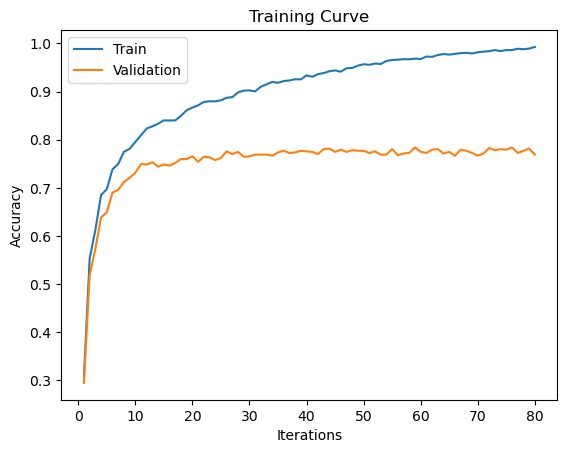

In [121]:
# Create an instance of the model.
model = ImagesResNetANN(dropout_rate = 0.2)

# Move the model to GPU if available.
model.to(device)

# Train the model
train_acc, val_acc = train_net(model, batch_size, train_loader, val_loader,
                                   learning_rate = 0.0001, num_epochs = 300)
n = len(train_acc)
plt.title("Training Curve")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [92]:
# Now we make inferences on the test set.
# Load the best model.
model_path = 'Models/best_images_model.pt'
model.load_state_dict(torch.load(model_path))
# Move the model to GPU if available.
model.to(device)
# Set the model to evaluation mode.
model.eval()
correct_test, total_test = 0, 0
predictions = []
pred_labels = []
# Iterate through the test set.
with torch.no_grad():
    for recordings, labels in test_loader:
        recordings = recordings.to(device)
        labels = labels.to(device)
        output = model(recordings)
        pred = output.max(1, keepdim=True)[1]
        correct_test += pred.eq(labels.view_as(pred)).sum().item()
        total_test += recordings.shape[0]
        predictions.extend(pred.cpu().numpy())
        pred_labels.extend(labels.cpu().numpy())
# Calculate test accuracy.
test_acc = correct_test / total_test
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.7770


/var/folders/s8/7wj664s92gx_89p1xhcwbq800000gn/T/ipykernel_14536/365461453.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
